# Simple example of using the transmission_models library

In [1]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.stats import nbinom, gamma, binom, expon
from math import factorial
import time

import os,sys


In [2]:

sys.path.append('../')
import transmission_models as tmod
from utils import hierarchy_pos,hierarchy_pos_times,plot_transmision_network,tree_to_newick,search_firsts_sampled_siblings
from transmission_models.models import didelot_unsampled as du
import transmission_models.utils as utils
from transmission_models.models.topology_movements import *
import transmission_models.models.MCMC.MCMC  as MCMC

# Loading parameters

In [3]:
sampling_params = {
                    "pi":0.47,
                    "k_samp":5.316,
                    "theta_samp":1.158
                }
offspring_params = {
                    "r":4.47,
                    "p_inf":0.62,
                }
infection_params = {
                    "k_inf": 5.70959959960973,
                    "theta_inf":1.061661377840768
                }

In [4]:
model = du(sampling_params, offspring_params, infection_params)

# Loading data

In [5]:
data_dir = "./data"
df = pd.read_csv(data_dir+"/49_nodes_icpmr_delta_gisaid.csv")
df['date_collection'] = pd.to_datetime(df['date_collection'])
df['date_submitted'] = pd.to_datetime(df['date_submitted'])
df["date_sample"] = (df["date_collection"]-df['date_collection'].min()).dt.days
df["t_inf_ini"] = df.apply(lambda row:row.date_sample-gamma.rvs(infection_params["k_inf"], loc=0, scale=infection_params["theta_inf"], size=1)[0] ,
                                       axis = 1)




In [6]:
data = []
for i, h in enumerate(df.iloc):
    host = tmod.host(h.strain, i, t_sample=h.date_sample, t_inf=h.t_inf_ini)
    data.append(host)

# Generating initial condition network

In [7]:
edge_list = []
K_dict = {h:model.samp_offspring() for h in data}

for i, h1 in enumerate(data[::-1]):
    P = 0
    event = False
    # print("--------", h1.t_inf)
    if i < 20:
        s = 0
    else:
        s = i
    K = model.samp_offspring()
    # print(K,h1)
    if K>0:
        for h2 in data[s::-1]:
            if int(h1) == int(h2):
                #             print(h2.index,h1.index,"kakakakak")
                continue
            # print(h2.t_inf-h1.t_inf>0,"kakakakak")
            if K_dict[h2] == 0:
                continue
            if h1.t_inf > h2.t_inf:
                P_new = model.pdf_infection(h1.t_inf - h2.t_inf)  # Es h2 mi padre?
                # print(h2.index, h1.index, P_new)

                if P < P_new:
                    P = P_new
                    h2_infec = h2
                    K_dict[h2] -= 1
                    event = True
                    # print("BINGO!!", P_new)
            # else:
                # print(h2.index, h1.index, "imposible")
        if event: 
            # print("inf!!!",h2_infec,h1)
            edge_list.append((h2_infec, h1))
        # else:
        #     print("NO",h1)
end_time = time.time()
model.T = nx.DiGraph()
model.T.add_edges_from(edge_list)

roots = [h for h in model.T if model.T.in_degree(h)==0]
# print(len(roots))
t_min = min(roots, key=lambda h:h.t_inf).t_inf

model.root_host = tmod.host("Virtual_host",-1,t_inf=t_min-1.5*model.Delta_crit)

for h in roots:
    model.T.add_edge(model.root_host,h)

for h in [h for h in data if h not in model.T]:
    model.T.add_edge(model.root_host,h)

# MCMC with no location and genetic information

In [8]:
mcmc = MCMC.MCMC(model)

In [9]:
N_burn = 2000
N_measure = 100

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(20000):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_likelihoods.append(model.log_likelihood)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Text(0.5, 0, 'log_likelihood')

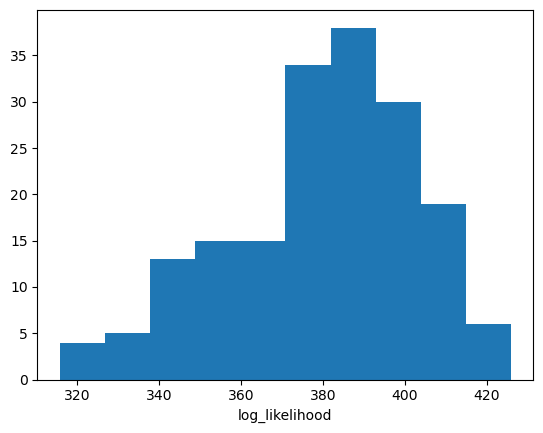

In [10]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

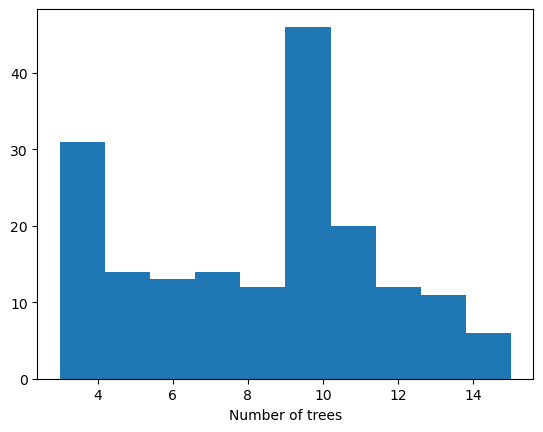

In [11]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

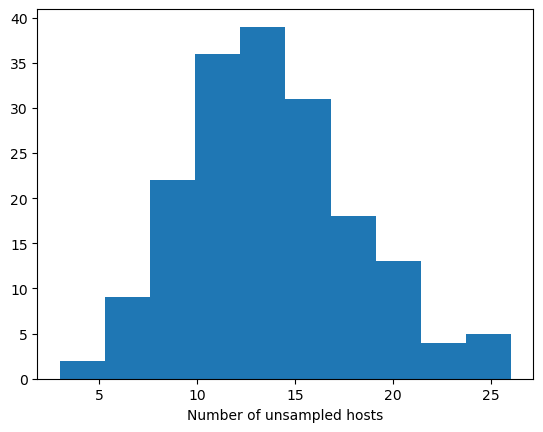

In [12]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

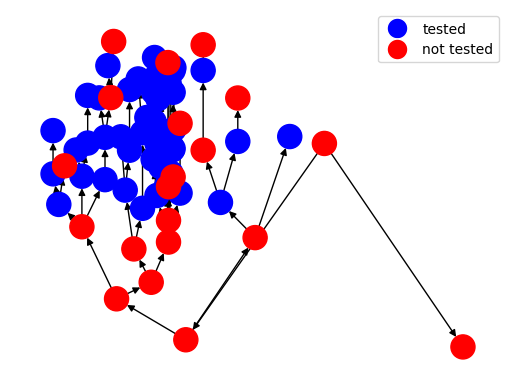

In [13]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)

# MCMC with location information

In [14]:

dist_df = pd.read_csv("./data/location_49_hosts.tsv",sep="\t", index_col="strain_x")


dist_loc = np.zeros((len(model.T),len(model.T)))
i=0
for h in model.T:
    print(h)
    if not h.sampled: continue
    if str(h) not in dist_df.index:
            dist_loc[int(h), :] = None
            dist_loc[:,int(h)] = None
            continue
    for h2 in model.T[h]:
        if str(h2) not in dist_df.index:
            dist_loc[int(h2), :] = None
            dist_loc[:,int(h2)] = None
            continue
        if not h2.sampled: continue
        i+=1
        dist_loc[int(h),int(h2)] = dist_df.loc[str(h),str(h2)]
        dist_loc[int(h2),int(h)] = dist_df.loc[str(h2),str(h)]
        # print(i,"---",dist_loc[int(h2),int(h)])

model.add_same_location_prior(0.1,15,dist_loc)
model.same_location_log_prior = model.same_location_prior.log_prior_T(model.T)

hCoV-19/Australia/NSW1634/2021
hCoV-19/Australia/NSW1668/2021
hCoV-19/Australia/NSW1666/2021
hCoV-19/Australia/NSW1705/2021
hCoV-19/Australia/NSW1762/2021
hCoV-19/Australia/NSW1732/2021
hCoV-19/Australia/NSW1761/2021
hCoV-19/Australia/NSW1703/2021
hCoV-19/Australia/NSW1760/2021
hCoV-19/Australia/NSW1643/2021
hCoV-19/Australia/NSW1748/2021
hCoV-19/Australia/NSW1661/2021
hCoV-19/Australia/NSW1743/2021
hCoV-19/Australia/NSW1656/2021
hCoV-19/Australia/NSW1739/2021
hCoV-19/Australia/NSW1672/2021
hCoV-19/Australia/NSW1662/2021
hCoV-19/Australia/NSW1729/2021
hCoV-19/Australia/NSW1660/2021
hCoV-19/Australia/NSW1728/2021
hCoV-19/Australia/NSW1727/2021
hCoV-19/Australia/NSW1713/2021
hCoV-19/Australia/NSW1708/2021
hCoV-19/Australia/NSW1680/2021
hCoV-19/Australia/NSW1678/2021
hCoV-19/Australia/NSW1652/2021
hCoV-19/Australia/NSW1658/2021
hCoV-19/Australia/NSW1665/2021
Virtual_host
hCoV-19/Australia/NSW1649/2021
hCoV-19/Australia/NSW1657/2021
hCoV-19/Australia/NSW1677/2021
hCoV-19/Australia/NSW1679/

In [15]:
mcmc = MCMC.MCMC(model)


In [16]:
N_burn = 2000
N_measure = 100

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(20000):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_likelihoods.append(model.log_likelihood+model.same_location_log_prior)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Text(0.5, 0, 'log_likelihood')

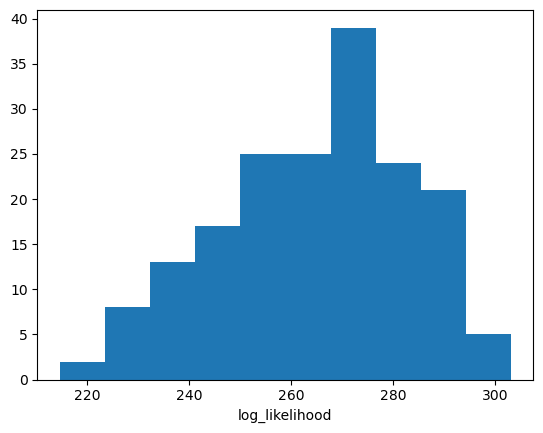

In [17]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

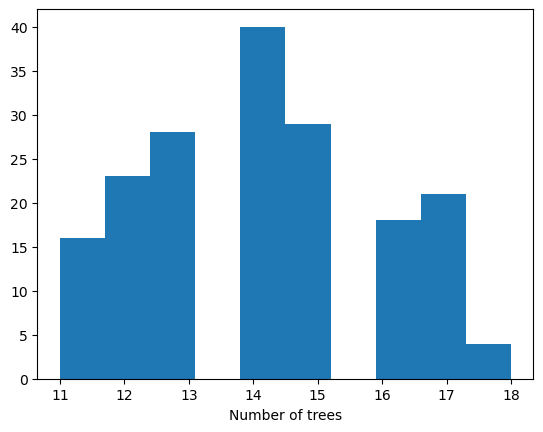

In [18]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

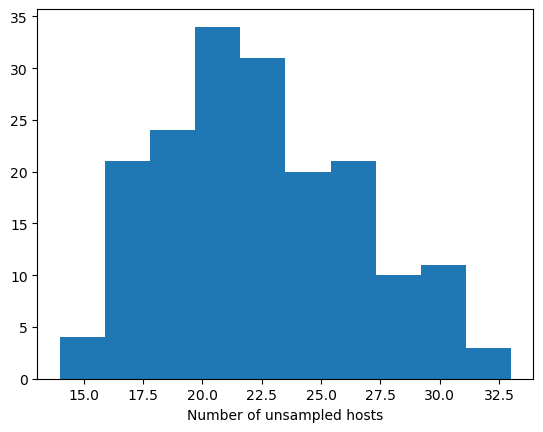

In [19]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

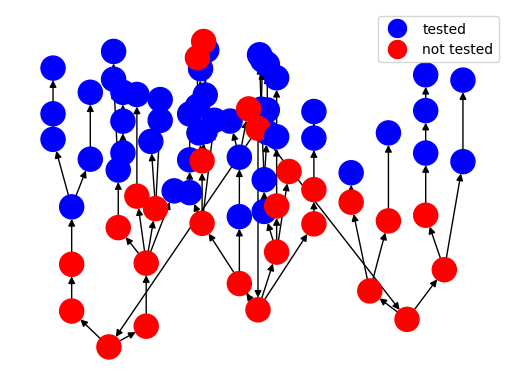

In [20]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)

In [21]:
dist_df

,hCoV-19/Australia/NSW1649/2021,hCoV-19/Australia/NSW1634/2021,hCoV-19/Australia/NSW1643/2021,hCoV-19/Australia/NSW1654/2021,hCoV-19/Australia/NSW1656/2021,hCoV-19/Australia/NSW1661/2021,hCoV-19/Australia/NSW1657/2021,hCoV-19/Australia/NSW1660/2021,hCoV-19/Australia/NSW1662/2021,hCoV-19/Australia/NSW1672/2021,...,hCoV-19/Australia/NSW1667/2021,hCoV-19/Australia/NSW1773/2021,hCoV-19/Australia/NSW1663/2021,hCoV-19/Australia/NSW1781/2021,hCoV-19/Australia/NSW1782/2021,hCoV-19/Australia/NSW1785/2021,hCoV-19/Australia/NSW1793/2021,hCoV-19/Australia/NSW1655/2021,hCoV-19/Australia/NSW1658/2021,hCoV-19/Australia/NSW1666/2021
strain_x,,,,,,,,,,,,,,,,,,,,,
hCoV-19/Australia/NSW1649/2021,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.00,0.02
hCoV-19/Australia/NSW1634/2021,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.04,0.01,0.01,0.00,0.00,0.01,0.01,0.03
hCoV-19/Australia/NSW1643/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1654/2021,0.01,0.01,0.01,0.00,0.02,0.01,0.01,0.01,0.01,0.01,...,0.00,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.00,0.03
hCoV-19/Australia/NSW1656/2021,0.01,0.01,0.01,0.02,0.00,0.01,0.01,0.01,0.01,0.01,...,0.01,0.02,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.02
hCoV-19/Australia/NSW1661/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1657/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1660/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.01,0.00,0.03
hCoV-19/Australia/NSW1662/2021,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.04,0.01,0.01,0.00,0.00,0.01,0.00,0.03


In [24]:
data_dir = "./data/genetic_49_hosts.tsv"
dist_df = pd.read_csv(data_dir,sep="\t",index_col=0)
dist_gen = np.zeros((len(model.T),len(model.T)))
i = 0
for h in model.T:
    if not h.sampled: continue
    for h2 in model.T[h]:
        if not h2.sampled: continue
        i+=1
        print(i,h,h2)
        dist_gen[int(h),int(h2)] = dist_df.loc[h.id,h2.id]
        dist_gen[int(h2),int(h)] = dist_df.loc[h2.id,h.id]

model.add_genetic_prior(0.1065,dist_gen)
model.genetic_log_prior = model.genetic_prior.log_prior_T(model.T)

1 hCoV-19/Australia/NSW1634/2021 hCoV-19/Australia/NSW1729/2021
2 hCoV-19/Australia/NSW1634/2021 hCoV-19/Australia/NSW1654/2021
3 hCoV-19/Australia/NSW1666/2021 hCoV-19/Australia/NSW1738/2021
4 hCoV-19/Australia/NSW1732/2021 hCoV-19/Australia/NSW1713/2021
5 hCoV-19/Australia/NSW1703/2021 hCoV-19/Australia/NSW1660/2021
6 hCoV-19/Australia/NSW1703/2021 hCoV-19/Australia/NSW1773/2021
7 hCoV-19/Australia/NSW1643/2021 hCoV-19/Australia/NSW1652/2021
8 hCoV-19/Australia/NSW1748/2021 hCoV-19/Australia/NSW1680/2021
9 hCoV-19/Australia/NSW1748/2021 hCoV-19/Australia/NSW1708/2021
10 hCoV-19/Australia/NSW1661/2021 hCoV-19/Australia/NSW1748/2021
11 hCoV-19/Australia/NSW1743/2021 hCoV-19/Australia/NSW1785/2021
12 hCoV-19/Australia/NSW1656/2021 hCoV-19/Australia/NSW1705/2021
13 hCoV-19/Australia/NSW1739/2021 hCoV-19/Australia/NSW1728/2021
14 hCoV-19/Australia/NSW1672/2021 hCoV-19/Australia/NSW1663/2021
15 hCoV-19/Australia/NSW1662/2021 hCoV-19/Australia/NSW1743/2021
16 hCoV-19/Australia/NSW1662/2021 

In [25]:
mcmc = MCMC.MCMC(model)

In [26]:
N_burn = 2000
N_measure = 100

log_likelihoods = []
N_trees = []
N_unsampleds = []

for itt in range(20000):
    proposal,gg,pp,P,accepted,DL = mcmc.MCMC_iteration()
    if itt>N_burn and itt%N_measure==0:
        log_likelihoods.append(model.log_likelihood)
        N_unsampleds.append(len(model.unsampled_hosts))        
        N_trees.append(len(search_firsts_sampled_siblings(model.root_host,model.T)))
    
    
    

Text(0.5, 0, 'log_likelihood')

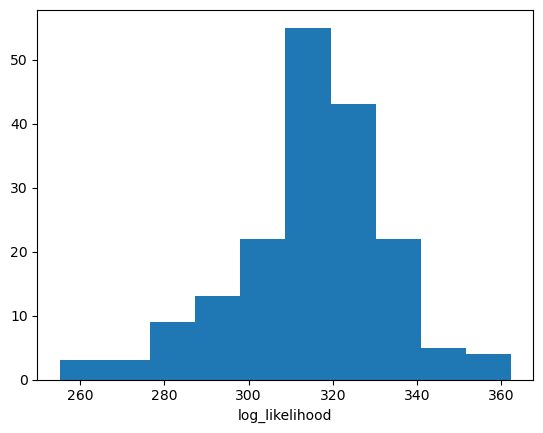

In [27]:
plt.hist(log_likelihoods)
plt.xlabel("log_likelihood")

Text(0.5, 0, 'Number of trees')

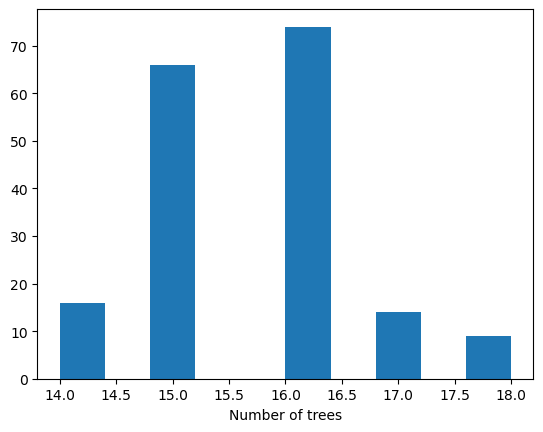

In [28]:
plt.hist(N_trees)
plt.xlabel("Number of trees")

Text(0.5, 0, 'Number of unsampled hosts')

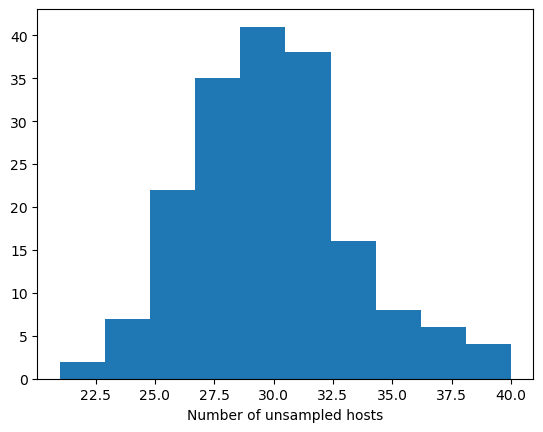

In [29]:
plt.hist(N_unsampleds)
plt.xlabel("Number of unsampled hosts")

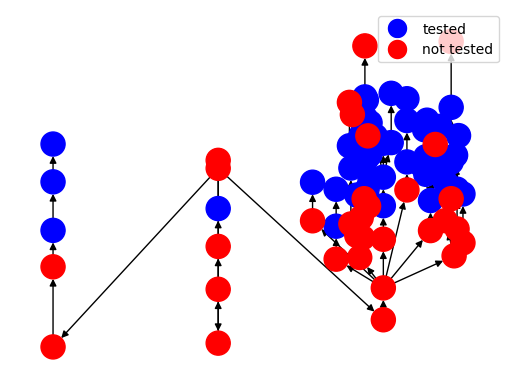

In [30]:
pos = hierarchy_pos_times(model.T, root=model.root_host, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5)

tmod.utils.plot_transmision_network(model.T,pos=pos)